# Match Documents to Questions

Matching documents to questions using the references for each question.

In [2]:
import os
# Setting temp dir to /srv/data directory, as it otherwise fills up the home directory too much
# Just comment out on machines that are not "Goober"
os.environ["TMPDIR"] = "/srv/data/tmp"
os.makedirs("/srv/data/tmp", exist_ok=True)

%pip install haystack-ai
%pip install nltk
%pip install markdown-it-py
%pip install mdit_plain
%pip install openai
%pip install pandas
%pip install hf_xet
%pip install ollama-haystack==2.4.2
%pip install rapidfuzz
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from tqdm import tqdm
import pandas as pd
from openai import OpenAI
from utils.pickle_utils import for_each_pickle_file
from utils.document_utils import find_matching_docs

tqdm.pandas()

In [5]:
def add_matching_documents_from_pkl_file(filename, df):
    question_answers_dataset = pd.read_pickle("data/datasets/question_answers_dataset_raw.pkl")
    documents = df["document"].tolist()
    question_answers_dataset["documents"] = question_answers_dataset["references"].apply(
        lambda refs: find_matching_docs(refs, documents)
    )
    question_answers_dataset.to_pickle(f"data/qa_with_docs/question_answers_{filename}_dataset.pkl")

for_each_pickle_file("data/preprocessed_documents", add_matching_documents_from_pkl_file)

Processing Pickle files: 100%|██████████| 6/6 [00:24<00:00,  4.05s/it]


## Dataset Validation

### Number of relevant chunks per question

Processing Pickle files: 100%|██████████| 6/6 [00:00<00:00, 721.39it/s]


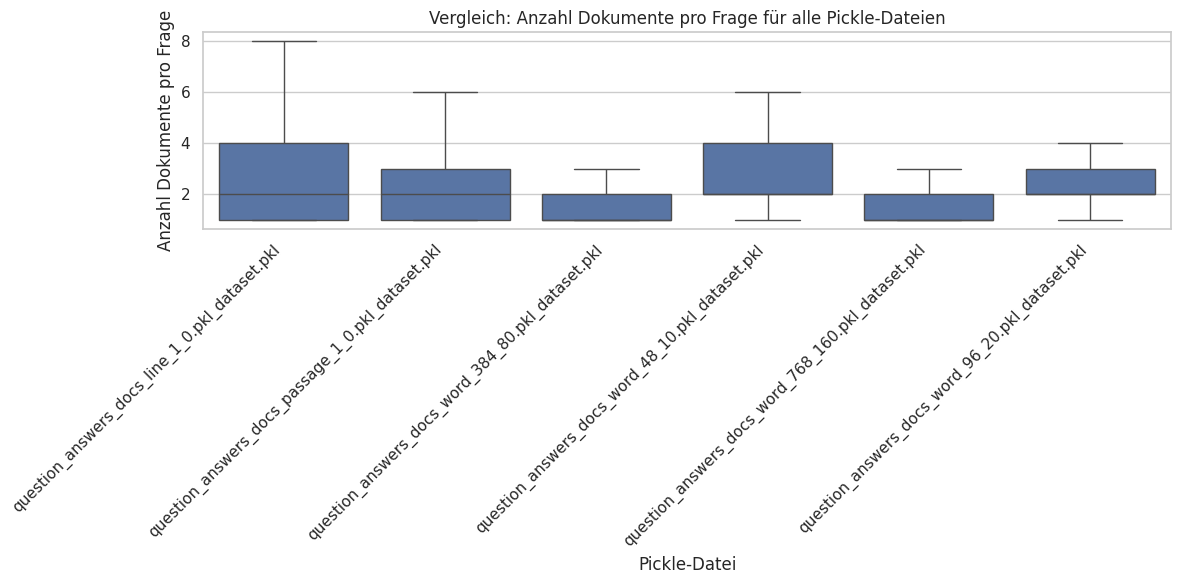

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# dieser globale Container sammelt alle Counts aus jedem einzelnen Pickle
records = []

def validate_qa_with_docs(filename, df):
    # Länge der Liste df["documents"] pro Frage
    doc_counts = df["documents"].apply(len)
    # für jede Count ein Record mit Dateiname
    for cnt in doc_counts:
        records.append({
            "file": filename,
            "doc_count": cnt
        })

# hier wird wie gewohnt über alle Pickles iteriert,
# our callback füllt nur 'records'
for_each_pickle_file("data/qa_with_docs", validate_qa_with_docs)

# nach der Schleife haben wir alles in records – jetzt einmaliges Boxplot
plot_df = pd.DataFrame(records)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=plot_df,
    x="file",
    y="doc_count",
    showfliers=False        # Ausreißer ausblenden, optional
)
plt.title("Vergleich: Anzahl Dokumente pro Frage für alle Pickle-Dateien")
plt.xlabel("Pickle-Datei")
plt.ylabel("Anzahl Dokumente pro Frage")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Check Reference to Document Mapping

Checks if the documents mapped to the question contain all the references from that question.

In [ ]:
from utils.string_utils import normalize
import pandas as pd

def find_missing_reference_matches_in_df(filename, df):
    # Show all columns, rows, and avoid truncating column content
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)

    def find_missing_refs(references, documents):
        normalized_refs = [normalize(ref) for ref in references if isinstance(ref, str)]
        normalized_doc_texts = [normalize(doc.content) for doc in documents]
        full_text = " ".join(normalized_doc_texts)
        # Return only those references not found in the text
        missing_refs = [ref for ref in normalized_refs if ref not in full_text]
        return missing_refs

    # Apply function to extract missing references
    df["missing_refs"] = df.apply(
        lambda row: find_missing_refs(row["references"], row["documents"]), axis=1
    )

    # Only keep rows with missing references
    failed_rows = df[df["missing_refs"].apply(len) > 0]

    print(f"f{filename}: {len(failed_rows)} rows have missing reference matches.")
    # print(failed_rows[["question", "references", "missing_refs", "documents"]])

for_each_pickle_file("data/qa_with_docs", find_missing_reference_matches_in_df)

Processing Pickle files: 100%|██████████| 6/6 [00:00<00:00, 131.29it/s]

fquestion_answers_docs_line_1_0.pkl_dataset.pkl: 2 rows have missing reference matches.
fquestion_answers_docs_passage_1_0.pkl_dataset.pkl: 1 rows have missing reference matches.
fquestion_answers_docs_word_384_80.pkl_dataset.pkl: 0 rows have missing reference matches.
fquestion_answers_docs_word_48_10.pkl_dataset.pkl: 38 rows have missing reference matches.
fquestion_answers_docs_word_768_160.pkl_dataset.pkl: 0 rows have missing reference matches.
fquestion_answers_docs_word_96_20.pkl_dataset.pkl: 5 rows have missing reference matches.


## Flatten Question Variations

In [5]:
df = pd.read_pickle("data/question_answers_with_documents.pkl")

In [16]:
import json
import pandas as pd
from tqdm import tqdm

new_rows = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Flattening Question Variations"):
    # 0) Include the original row itself
    orig = row.copy()
    orig["variant"]       = "default"
    orig["prev_messages"] = []
    new_rows.append(orig)

    # 1) Unpack each variation
    variations = json.loads(row["variations"])
    for variation_key, variation_val in variations.items():
        nr = row.copy()
        nr["variant"] = variation_key

        if variation_key == "contextual" and isinstance(variation_val, list):
            nr["question"]      = variation_val[-1]["message"]
            nr["prev_messages"] = [m["message"] for m in variation_val[:-1]]
        else:
            nr["question"]      = variation_val
            nr["prev_messages"] = []

        new_rows.append(nr)

# 2) Build your flattened DataFrame and drop 'variations'
flat_df = (
    pd.DataFrame(new_rows)
      .reset_index(drop=True)
      .drop(columns=["variations"])
)

Flattening Question Variations:   0%|          | 0/61 [00:00<?, ?it/s]

Flattening Question Variations: 100%|██████████| 61/61 [00:00<00:00, 231.07it/s]


In [17]:
flat_df

,question,references,groundTruth,source_file,documents,variant,prev_messages
0,Wie läuft eine äußere Wendung ab und was passi...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=ea0c518b7c51e474b09770e8db9709652...,default,[]
1,Und wie lange dauert dieser Eingriff normalerw...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=ea0c518b7c51e474b09770e8db9709652...,contextual,"[Wie läuft eine äußere Wendung ab?, Bei der äu..."
2,"Ey, wie machen die eigentlich so 'ne äußere We...",[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=ea0c518b7c51e474b09770e8db9709652...,slang,[]
3,How is an external version done and what happe...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=ea0c518b7c51e474b09770e8db9709652...,english,[]
4,"Können Sie mir erklären, wie eine äußere Wendu...",[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=ea0c518b7c51e474b09770e8db9709652...,german-variation-1,[]
...,...,...,...,...,...,...,...
605,"Was ist zu tun, wenn nach der Geburtseinleitun...",[Bei jeder medikamentösen oder mechanischen Me...,Sollten nach der Geburtseinleitung starke oder...,Einleitung der Geburt.md,[Document(id=8a64407f7a87fa95d3ce2f268e6b00c66...,german-variation-2,[]
606,"Kann mir jemand sagen, was ich machen soll, we...",[Bei jeder medikamentösen oder mechanischen Me...,Sollten nach der Geburtseinleitung starke oder...,Einleitung der Geburt.md,[Document(id=8a64407f7a87fa95d3ce2f268e6b00c66...,german-variation-3,[]
607,Ich hatte eine Geburtseinleitung – was mache i...,[Bei jeder medikamentösen oder mechanischen Me...,Sollten nach der Geburtseinleitung starke oder...,Einleitung der Geburt.md,[Document(id=8a64407f7a87fa95d3ce2f268e6b00c66...,german-variation-4,[]
608,"Was empfehlen Sie, wenn nach der Einleitung de...",[Bei jeder medikamentösen oder mechanischen Me...,Sollten nach der Geburtseinleitung starke oder...,Einleitung der Geburt.md,[Document(id=8a64407f7a87fa95d3ce2f268e6b00c66...,german-variation-5,[]


In [18]:
flat_df.to_pickle("data/question_answers_with_documents_flat.pkl")